# Gated Recurrent Units (GRU)

As RNNs and particularly the LSTM architecture
rapidly gained popularity during the 2010s,
a number of papers began to experiment 
with simplified architectures in hopes 
of retaining the key idea of incorporating
an internal state and multiplicative gating mechanisms
but with the aim of speeding up computation.
The gated recurrent unit (GRU) (`Cho.Van-Merrienboer.Bahdanau.ea.2014`) 
offered a streamlined version of the LSTM memory cell
that often achieves comparable performance
but with the advantage of being faster 
to compute.


## Reset Gate and Update Gate

Here, the LSTM's three gates are replaced by two:
the *reset gate* and the *update gate*.
As with LSTMs, these gates are given sigmoid activations,
forcing their values to lie in the interval $(0, 1)$.
Intuitively, the reset gate controls how much of the previous state 
we might still want to remember.
Likewise, an update gate would allow us to control 
how much of the new state is just a copy of the old state.
The outputs of two gates are given 
by two fully connected layers
with a sigmoid activation function.


Mathematically, for a given time step $t$,
suppose that the input is a minibatch
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$ 
(number of examples: $n$, number of inputs: $d$)
and the hidden state of the previous time step 
is $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$ 
(number of hidden units: $h$). 
Then, the reset gate $\mathbf{R}_t \in \mathbb{R}^{n \times h}$ 
and update gate $\mathbf{Z}_t \in \mathbb{R}^{n \times h}$ are computed as follows:

$$
\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z),
\end{aligned}
$$

where $\mathbf{W}_{xr}, \mathbf{W}_{xz} \in \mathbb{R}^{d \times h}$ 
and $\mathbf{W}_{hr}, \mathbf{W}_{hz} \in \mathbb{R}^{h \times h}$ 
are weight parameters and $\mathbf{b}_r, \mathbf{b}_z \in \mathbb{R}^{1 \times h}$ 
are bias parameters.


## Candidate Hidden State

Next, we integrate the reset gate $\mathbf{R}_t$ 
with the regular updating mechanism,
leading to the following
*candidate hidden state*
$\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}$ at time step $t$:

$$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h),$$
:eqlabel:`gru_tilde_H`

where $\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$
are weight parameters,
$\mathbf{b}_h \in \mathbb{R}^{1 \times h}$
is the bias,
and the symbol $\odot$ is the Hadamard (elementwise) product operator.
Here we use a tanh activation function.

The result is a *candidate*, since we still need 
to incorporate the action of the update gate.
The influence of the previous states
can be reduced with the
elementwise multiplication of
$\mathbf{R}_t$ and $\mathbf{H}_{t-1}$
in :eqref:`gru_tilde_H`.
Whenever the entries in the reset gate $\mathbf{R}_t$ are close to 1, 
we recover a vanilla RNN.
For all entries of the reset gate $\mathbf{R}_t$ that are close to 0, 
the candidate hidden state is the result of an MLP with $\mathbf{X}_t$ as input. 
Any pre-existing hidden state is thus *reset* to defaults.


## Hidden State

Finally, we need to incorporate the effect of the update gate $\mathbf{Z}_t$.
This determines the extent to which the new hidden state $\mathbf{H}_t \in \mathbb{R}^{n \times h}$ 
matches the old state $\mathbf{H}_{t-1}$ versus how much 
it resembles the new candidate state $\tilde{\mathbf{H}}_t$.
The update gate $\mathbf{Z}_t$ can be used for this purpose, 
simply by taking elementwise convex combinations 
of $\mathbf{H}_{t-1}$ and $\tilde{\mathbf{H}}_t$.
This leads to the final update equation for the GRU:

$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t.$$


Whenever the update gate $\mathbf{Z}_t$ is close to 1,
we simply retain the old state. 
In this case the information from $\mathbf{X}_t$ is ignored, 
effectively skipping time step $t$ in the dependency chain. 
In contrast, whenever $\mathbf{Z}_t$ is close to 0,
the new latent state $\mathbf{H}_t$ approaches the candidate latent state $\tilde{\mathbf{H}}_t$. 

In summary, GRUs have the following two distinguishing features:

* Reset gates help capture short-term dependencies in sequences.
* Update gates help capture long-term dependencies in sequences.

## Implementation of GRU from Scratch

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### Initializing Model Parameters

The first step is to initialize the model parameters.
We draw the weights from a Gaussian distribution
with standard deviation to be `sigma` and set the bias to 0. 
The hyperparameter `num_hiddens` defines the number of hidden units.
We instantiate all weights and biases relating to the update gate, 
the reset gate, and the candidate hidden state.


In [5]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # parameters of update gate
    W_xr, W_hr, b_r = three()  # parameters of reset gate
    W_xh, W_hh, b_h = three()  # candidate hidden state
    # parameters of the output layer
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # gradient
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### Defining the Model

Now we are ready to **define the GRU forward computation**.
Its structure is the same as that of the basic RNN cell, 
except that the update equations are more complex.


In [7]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), ) # return a tuple

In [9]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z) # @: matrix multiplication
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilde = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilde
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

### Training

**Training** a language model on *The Time Machine* dataset
works in exactly the same manner as in the implementation of RNN from scratch.


perplexity 1.1, 22192.7 tokens/sec on cpu
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


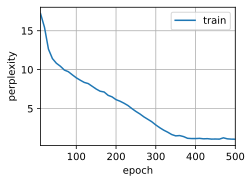

In [10]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, 
                            get_params, init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Concise Implementation

In high-level APIs, we can directly instantiate a GRU model.
This encapsulates all the configuration detail that we made explicit above.


perplexity 1.0, 30082.0 tokens/sec on cpu
time traveller with a slight accession ofcheerfulness really thi
travelleryou can show black is white by argument said filby


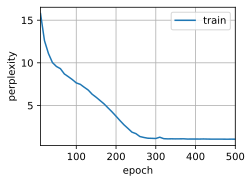

In [11]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

The code is significantly faster in training as it uses compiled operators 
rather than Python.


## Summary

Compared with LSTMs, GRUs achieve similar performance but tend to be lighter computationally.
Generally, compared with simple RNNs, gated RNNs like LSTMs and GRUs
can better capture dependencies for sequences with large time step distances.
GRUs contain basic RNNs as their extreme case whenever the reset gate is switched on. 
They can also skip subsequences by turning on the update gate.
